# Exploratory Data Analysis (EDA) with Python
### "Tidy datasets are all alike, but every messy dataset is messy in its own way"

## Welcome!

This workshop aims at giving you a starter to independently work with your data throughout the *“data analysis lifecycle”* — from **importing**, **cleaning**, **visualising** and **summarising** the data to **analysing**.

<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/data_loop.png?raw=1" width="50%"/>

To follow this tutorial, you need some familiarity with common libraries such as **pandas**, **matplotlib** and **seaborn**.

**Now let’s get started!**

Incorrect or inconsistent data leads to false conclusions. And so, how well you clean and understand the data has a high impact on the quality of the results.

In fact, a simple algorithm can outweigh a complex one just because it was given enough and high-quality data.

For these reasons, it is important to have a step-by-step guideline, a cheat sheet, that walks through the quality checks to be applied.



***
## ℹ️ **Learning objectives**

- Understand data-type constraints, checks and the role of data cleaning techniques in standardising data formats, handling missing values, and addressing outliers;
- Develop exploratory data analysis skills to visualise data distributions, detect outliers, and explore relationships between variables.
***

## The dataset

The *Stack Overflow Developer Survey* is a highly anticipated annual event that provides valuable insights into the preferences, trends, and experiences of developers worldwide. In May 2023, over 90,000 developers participated in the survey, sharing their perspectives on learning methods, preferred tools, and salary trends. The [latest dataset 2023](https://survey.stackoverflow.co/2023/) is available [here](https://insights.stackoverflow.com/survey/).

<a href="https://survey.stackoverflow.co/2023/">
<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/so2023.png?raw=1" width="50%"/>
</a>

This is the voice of the developer. Analysts, IT leaders, reporters, and other developers turn to this report to stay up to date with the evolving developer experience, technologies that are rising or falling in favor, and to understand where tech might be going next.

In the early stages of EDA you are encouraged to explore every idea that comes to mind, which is usually guided by your research question. While some of the early ideas will prove fruitful, others may lead to dead ends. As your exploration continues, you will narrow down a few insightful findings that you'll eventually write up and communicate to others.

## Table of Contents
1. [Import your libraries and data](#basics)
2. [Data semantics](#semantics)
3. [Inspection and cleaning](#cleaning)
4. [In-record & cross-dataset errors](#errors)
5. [Duplicates](#duplicates)
6. [Standardise](#standardise)
7. [Categorical data](#categorical)
8. [Select Variables and Filter Observations](#select_filter)
9. [Unusual values](#unusual_values)
    - [Outliers](#outliers)
    - [Missing values](#missing)
        - [Drop](#drop)
        - [Impute](#impute)
10. [Relationship](#relationship)
    - [Correlation](#correlation)
11. [Verifying](#verifying)
    - [Accuracy](#accuracy)
    - [Completeness](#completeness)
    - [Consistency](#consistency)
    - [Uniformity](#uniformity)
    - [Reporting](#reporting)
12. [What's next](#next)


<a id='basics'></a>
## Import your libraries and your data

We must first ensure that we have all the Python libraries we will use installed and available to us in this Google Colab environment. This first cell will take care of this.

In [1]:
!git clone https://github.com/Sydney-Informatics-Hub/EDAinPy.git
!pip install -r EDAinPy/requirements.txt

fatal: destination path 'EDAinPy' already exists and is not an empty directory.


It is common practice to load all the packages and modules that we will use in our first code cell. In this workshop we will _also_ import packages and modules as we use them, just so that is clear where particular tools come from, but you would not do this generally.

In [1]:
import os
import requests #to download the file from url
import zipfile #to extract the zip file
import pandas as pd
import janitor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim, clean_columns
from ydata_profiling import ProfileReport
from datascroller import scroll
from itables import show
import matplotlib.ticker as mtick
# import missingno as msno
import sweetviz as sv

Next we will download our data. The data is contained within a ZIP file that you can download directly from the Stack Overflow website [here](https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip). Once downloaded, the CSV (comma separated values) file with the survey results can be extracted from the ZIP file, and manually uploaded into this Google Colab environment using the menus on the left.

Alternatively, the code block below automates this task. It checks to see if the ZIP file has already been downloaded and, if not, requests it from the website and saves it. It then checks to see if the CSV file has already been extracted from the ZIP file and, if not, extracts all the files.

In [2]:
# Define the destination file
destfile = 'stack-overflow-developer-survey-2023.zip'

# Download the file if it doesn't exist
if not os.path.exists(destfile):
    url = 'https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip'
    response = requests.get(url) #sends a HTTP GET request to the specified URL to download the file
    with open(destfile, 'wb') as file: #write-binary mode
        file.write(response.content)

# Extract the files from the zip if they haven't been already
data_file = "survey_results_public.csv"
if not os.path.exists(data_file):
    with zipfile.ZipFile(destfile, 'r') as z: #opens the zip file in read mode and assigns the opened zip file object to the variable z
        #the with statement ensures that z.close() is called automatically when the block inside the with statement is exited
        z.extractall()

Now, we will load in the CSV file into a Pandas DataFrame and store it as a variable called `survey_raw`:

In [3]:
import pandas as pd

survey_raw = pd.read_csv(data_file)

# Display the first lines of content of the DataFrame
survey_raw.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


You can read more about how to import different formats of data into Python [here](https://images.datacamp.com/image/upload/v1676302004/Marketing/Blog/Importing_Data_Cheat_Sheet.pdf).

Looking at the table above, we see the [`head()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) returns the first five rows of the DataFrame. You can specify how many rows you want by passing the number as a parameter to the function (e.g. `head(10)`). The [`tail()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.tail.html) works in a similar way for the last rows of the table.

Look now at the number of columns. At the bottom of the table it says there are 84 columns, but only the first and last 10 are shown by default. If we want to see all columns, it is possible to change the settings of Pandas to achieve this. Alternatively, we can use the `itables` package that will display Pandas DataFrames as interactive tables, allowing us to scroll, as well as sort, paginate, and filter.

In [ ]:
from itables import show

show(survey_raw.head())


Now that we have seen how to import a dataset, we can start the process of “cleaning” it.
Cleaning, processing, wrangling, tidying, etc are all synonyms you may have heard being used for this process.

<a id='semantics'></a>
## Data semantics

A dataset is a collection of *values*, usually either numbers (if quantitative) or strings (if qualitative). Every value belongs to a **variable** and an **observation**:

-   A variable contains all values that measure the same underlying attribute (like height, temperature, duration) across units;

-   An observation contains all values measured on the same unit (like a person, or a day, or a race) across attributes.

A dataset is messy or clean/tidy depending on how rows and columns are matched up with observations and variables. In **tidy data**:

-   Each variable is a column;

-   Each observation is a row;

-   Each cell is a single measurement.

<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/tidy_data.png?raw=1" width="70%"/>

**Messy data** is any other arrangement of the data. There are common problems that can arise when dealing with messy datasets. There are a number of actions you can take on a dataset to tidy the data depending on the problem.
These include: *filtering*, *transforming*, *modifying variables*, *aggregating the data*, and *sorting the order of the observations*. We will see some of this later in this tutorial.

Here is a [link](https://byuidatascience.github.io/python4ds/tidy-data.html) to some material you can use to better understand how to tidy messy datasets.

***
### ▶️ **It's your turn!** ###

Have a look at your survey_raw object.
Is your dataset tidy or messy?

<details>
<summary>Solution</summary>

We can gain a lot of information by just viewing the data itself:

```python
survey_raw.head()
```
</details>

***

<a id='cleaning'></a>
## Inspection and cleaning

Data cleaning is an iterative process:

-   We won't get everything right the first time around;
-   We might improve or find a better way;
-   There isn't always a clear place to start, but we have to start somewhere.

<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/research_framework.png?raw=1" width="50%"/>

One good place to start is getting an overview of the dataset and check for *data-type constraints*. You can do this by calling the [`info()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) on a pandas DataFrame.

> DATA-TYPE CONSTRAINTS: Make sure numbers are stored as numerical data types. A date should be stored as a date object, and so on.

In [4]:
survey_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

This function provides a concise summary of the DataFrame. Here's what each part of the output means:

- `<class 'pandas.core.frame.DataFrame'>`: survey_raw is a pandas DataFrame.

- `RangeIndex: 89184 entries, 0 to 89183`: your DataFrame has 89,184 rows. The index for these rows ranges from 0 to 89,183.

- `Data columns (total 84 columns)`: your DataFrame has 84 columns.

The next section lists each column in your DataFrame, along with the number of non-null entries and the data type for each column. For example,
 
 ` 0   ResponseId                           89184 non-null  int64` 
 
 tells you that the first (or rather zeroth) column is called `ResponseId`, it has 89,184 non-null entries, and is of type `int64`.

- `dtypes: float64(3), int64(1), object(80)`: your DataFrame has 3 columns of type `float64`, 1 column of type `int64`, and 80 columns of type `object`.

- `memory usage: 57.2+ MB`: your DataFrame is using over 57.2 megabytes of memory.

From this output, you can see that most of your columns are of type object, which usually means they contain strings or pandas could not infer a more specific data type. You also have some missing values in many columns, as the number of non-null entries is less than the total number of rows for those columns.

### Unique identifiers

The first variable `ResponseId` looks like a unique identifier. Each subject should have their own ID such that all data are properly attributed to that subject.

> UNIQUE CONSTRAINT: a particular observation unit identifiable and distinct from all other observational units

Often, it can be helpful to have a way of recording the source of each row in our original dataset (in this case, our subject), so we can trace the data from this row as we work with the data. We can use the [`unique()` method](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) on a column to obtain an array that only contains its unique values. The code below checks to see if the length of the unique values in the column `ResponseId` is the same as the length of the dataset. If it is, it will return `True` and we can be confident it is a unique identifier.

In [5]:
# Check if 'ResponseId' uniquely identifies each row
len(survey_raw) == len(survey_raw['ResponseId'].unique())

True

We can accomplish the same by calling the [`duplicated()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) on the column. This method returns a series of `True` and `False` values that denote duplicate rows. The default behaviour of this method is to mark duplicates as `True` except for the first occurance. 

In [6]:
# check for duplicate values in ResponseId column
duplicate_values = survey_raw['ResponseId'].duplicated()

# show result
duplicate_values

0        False
1        False
2        False
3        False
4        False
         ...  
89179    False
89180    False
89181    False
89182    False
89183    False
Name: ResponseId, Length: 89184, dtype: bool

Because `True` also has the numeric value `1` and `False` has the value `0`, we can sum over this series to get a count of how many duplicated values there are.

In [7]:
# Count duplicates
sum(duplicate_values)

0

### Cleaning column names

When we look at the list of column names, we can see that they are all in the *CamelCase* format, that is, each new word starts with an uppercase letter with no spaces. Sometimes the data sets we work with don't have this consistency, which makes them more difficult to work with - how do you keep track of which variable is written in which format? At other times, we may want to change the way the column name is formatted. For example, in Python, the naming convention for variable names is that they are written in *snake_case* (that is, lowercase and separate words with underscores).

If we want to uniformly change the column names so they have a particular format, it would be painful to change them all individually. Instead, we can use the [`clean_columns` function](https://aeturrell.github.io/skimpy/reference/clean_columns.html) that can be found in the `skimpy` library. If we apply it to our DataFrame, we can see that the column names are converted from CamelCase to snake_case.

In [8]:
from skimpy import clean_columns #clean_columns comes from skimpy

survey_cleaned = clean_columns(survey_raw)
survey_cleaned.columns.to_list()

Index(['response_id', 'q_120', 'main_branch', 'age', 'employment',
       'remote_work', 'coding_activities', 'ed_level', 'learn_code',
       'learn_code_online', 'learn_code_courses_cert', 'years_code',
       'years_code_pro', 'dev_type', 'org_size', 'purchase_influence',
       'tech_list', 'buy_new_tool', 'country', 'currency', 'comp_total',
       'language_have_worked_with', 'language_want_to_work_with',
       'database_have_worked_with', 'database_want_to_work_with',
       'platform_have_worked_with', 'platform_want_to_work_with',
       'webframe_have_worked_with', 'webframe_want_to_work_with',
       'misc_tech_have_worked_with', 'misc_tech_want_to_work_with',
       'tools_tech_have_worked_with', 'tools_tech_want_to_work_with',
       'new_collab_tools_have_worked_with',
       'new_collab_tools_want_to_work_with', 'op_sys_personal_use',
       'op_sys_professional_use', 'office_stack_async_have_worked_with',
       'office_stack_async_want_to_work_with',
       'office_st

While snake_case is the default style returned by `clean_columns`, there is the option to select other styles, as detailed in the [function documentation](https://aeturrell.github.io/skimpy/reference/clean_columns.html).

### Reducing categories and renaming variables

When we had a look at our data, you might have noticed that some variables have many levels. We may want to collapse these levels into fewer categories for several reasons:

- Collapsing levels can simplify the analysis and interpretation of results, especially when dealing with a large number of categories;
- In predictive modelling, reducing the number of levels in categorical variables can help improve model performance by reducing the complexity of the model;
- Collapsing infrequent levels into broader categories can help address issues of sparsity, where certain levels have very few observations, which may lead to unreliable estimates.

For example, the `coding_activities` variable has many levels:

In [8]:
# Count occurrences of 'coding_activities'
show(survey_cleaned['coding_activities'].value_counts(dropna=False))

But what does this variable represent?
Some variable names are not easily understandable.
Details on the questions asked in the survey are provided in the document `survey_result_schema.csv`. You can read this document in the same way you read in the stackoverflow survey dataset, with the `read_csv()` function:

In [9]:
survey_schema = pd.read_csv("survey_results_schema.csv")

# Clean column names
survey_schema_cleaned = survey_schema.clean_names(column_names='qname', case_type='snake', axis=None)

# explore the question variable
show(survey_schema_cleaned)

Now that we know that our `coding_activities` variable is related to whether the participants code as a hobby or for things work-related, we can rename this column as `coding_as_hobby`.

Similarly, the column `converted_comp_yearly` stands for the annual salary of the respondents in USD. We can change the name of column to `salary_usd` for easier understanding.

Below we create a dictionary called `lookup` that maps old names to new names for several columns. We can then pass this dictionary to the [`rename()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) of the DataFrame to get a new DataFrame with the changed column names.

In [10]:
# Columns to be renamed
lookup = {
    "converted_comp_yearly": "salary_usd",
    "main_branch": "profession",
    "coding_activities": "coding_as_hobby",
    "years_code_pro": "years_professional_coding",
    "org_size": "company_size",
    "work_exp": "years_work_exp",
    "i_cor_pm": "manager_role"
}

# Rename columns
survey_renamed = survey_cleaned.rename(columns=lookup)

# Check the new list of column names
survey_renamed.columns.tolist()


['response_id',
 'q_120',
 'profession',
 'age',
 'employment',
 'remote_work',
 'coding_as_hobby',
 'ed_level',
 'learn_code',
 'learn_code_online',
 'learn_code_courses_cert',
 'years_code',
 'years_professional_coding',
 'dev_type',
 'company_size',
 'purchase_influence',
 'tech_list',
 'buy_new_tool',
 'country',
 'currency',
 'comp_total',
 'language_have_worked_with',
 'language_want_to_work_with',
 'database_have_worked_with',
 'database_want_to_work_with',
 'platform_have_worked_with',
 'platform_want_to_work_with',
 'webframe_have_worked_with',
 'webframe_want_to_work_with',
 'misc_tech_have_worked_with',
 'misc_tech_want_to_work_with',
 'tools_tech_have_worked_with',
 'tools_tech_want_to_work_with',
 'new_collab_tools_have_worked_with',
 'new_collab_tools_want_to_work_with',
 'op_sys_personal_use',
 'op_sys_professional_use',
 'office_stack_async_have_worked_with',
 'office_stack_async_want_to_work_with',
 'office_stack_sync_have_worked_with',
 'office_stack_sync_want_to_work

Let's go back to our `coding_as_hobby` variable:

In [11]:
# Count occurrences of 'coding_activities'
show(survey_renamed['coding_as_hobby'].value_counts(dropna=False))

There are lots of values and in this case it would be much easier to make this variable binary:

- `yes`- the respondent codes outside of work (as hobby);
- `no`- the respondent doesn’t code outside of work.

When we want to do something like this, we can define a Python function that calculates the conversion. We can then use the [`apply() method`](https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) to apply this function to a column.

Below we first copy the `survey_renamed` DataFrame into a new version called `survey_hobby`. We apply the `map_hobby` function to the `coding_as_hobby` variable and assign the result into a new variable called `coding_as_hobby_clean`:

In [ ]:
# Map value to "yes" or "no"
def map_hobby(value):
    if pd.isna(value): # Keep NaN values as is
        return value
    if isinstance(value,str): # Check if the value is a string
        if "Hobby" in value:
            return "yes"
    return "no"

# Make a new copy of our dataframe
survey_hobby = survey_renamed.copy()

# Apply our function and save the result as a new variable
survey_hobby['coding_as_hobby_clean'] = survey_hobby['coding_as_hobby'].apply(map_hobby)

# Look at the result
survey_hobby['coding_as_hobby_clean']

Because the data in this variable only takes on a limited number of possible values, we can explicitly make this into a [`Categorical`](https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html) object.

In [ ]:
survey_hobby['coding_as_hobby_clean'] = pd.Categorical(survey_hobby['coding_as_hobby_clean'])

# Look at the result now
survey_hobby['coding_as_hobby_clean']

How can we visualise how many respondents engage in coding as a hobby?
Let's compare how the `coding_as_hobby` and `coding_as_hobby_clean` variables are visualised in a bar plot:

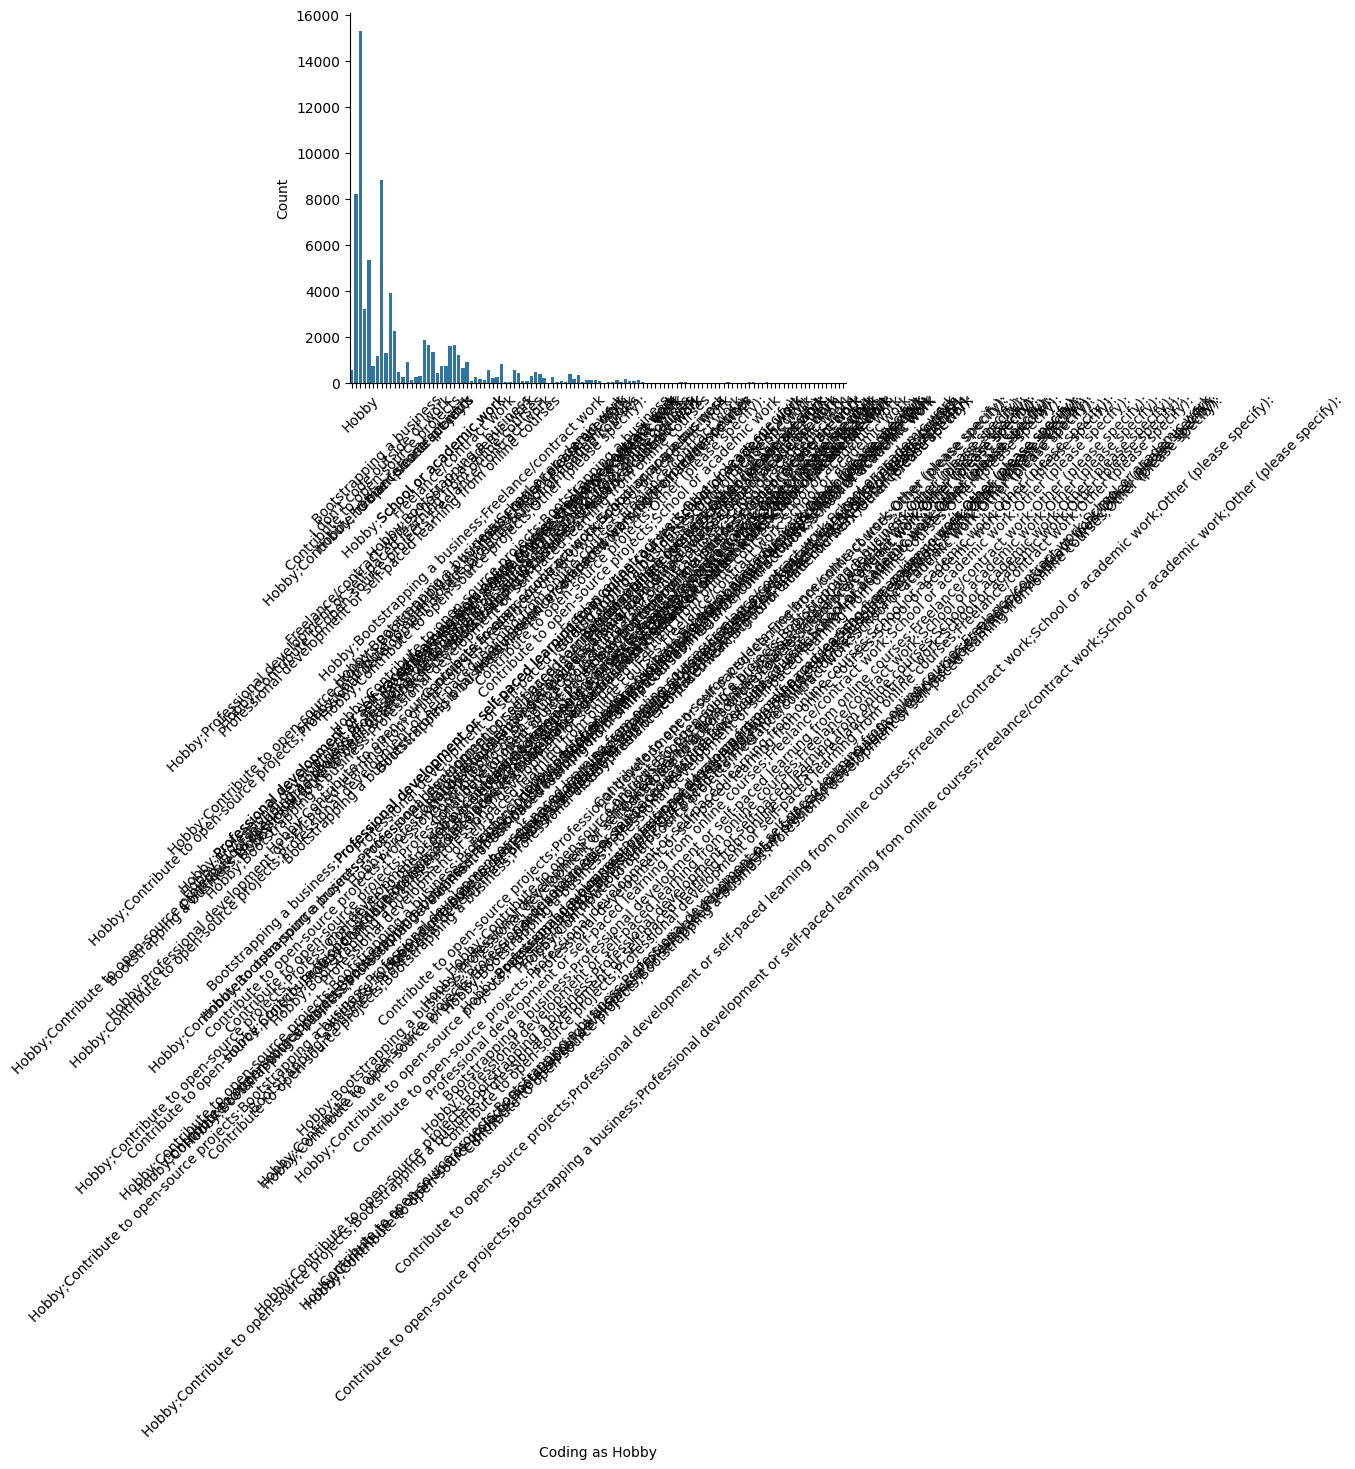

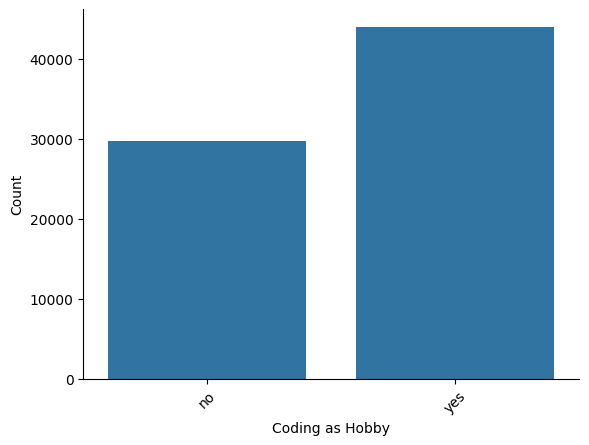

In [13]:
# Plot with matplotlib and seaborn libraries
import matplotlib.pyplot as plt
import seaborn as sns

#raw variable
sns.countplot(data=survey_hobby, x='coding_as_hobby')
plt.xticks(rotation=45)
plt.xlabel('Coding as Hobby')
plt.ylabel('Count')
sns.despine()  # To achieve a classic-looking theme without gridlines
plt.show()

#cleaned variable
sns.countplot(data=survey_hobby, x='coding_as_hobby_clean')
plt.xlabel('Coding as Hobby')
plt.ylabel('Count')
sns.despine()  # To achieve a classic-looking theme without gridlines
plt.show()

<a id='errors'></a>
## In-record & cross-dataset errors

These errors result from having two or more values in the same row or across datasets that contradict with each other.

For example, if we have a dataset about the cost of living in cities. The total column must be equivalent to the sum of rent, transport, and food. Similarly, a child can’t be married. An employee’s salary can’t be less than the calculated taxes.

The same idea applies to related data across different datasets.

Looking at our dataset, you can notice that some respondents have provided conflicting information about their *employment status* (e.g. variable `employment` levels: `Employed, full-time;Not employed, but looking for work` or `Not employed, but looking for work;Not employed, and not looking for work`):

In [14]:
# Explore the 'employment' variable
show(survey_hobby['employment'].value_counts(dropna=False))

As it is not possible to reach out to the respondents who provided such responses, we might *correct* them, if it’s clear what the correct response should be, or we may choose to *remove* these responses if they cannot be resolved. If you look at the `count` column, you can see that the number of respondents giving conflicting answers is less than 30. We can recode these respondent’s answers to the employment variable as `“unknown”` (**flagging**).

In [15]:
# Define the function to clean the employment column
def clean_employment(employment):
    if pd.isna(employment):
        return employment  # Keep NaN values as is
    if "Employed" in employment and "Not employed" in employment:
        return "unknown"
    if "but" in employment and "and" in employment:
        return "unknown"
    return employment

# Apply the function to create the employment_clean column
survey_employment = survey_hobby.copy()
survey_employment['employment_clean'] = survey_employment['employment'].apply(clean_employment)


We can now map each value to either `“employed”`, `“self-employed”`, `“student”`, `“retired”`, `“not_employed”` or `“unknown”`:

In [16]:
# Define the function to further clean the employment_clean column
def further_clean_employment(employment_clean):
    if pd.isna(employment_clean):
        return np.nan
    if "Employed" in employment_clean:
        return "employed"
    if "freelancer" in employment_clean:
        return "self_employed"
    if "Student" in employment_clean:
        return "student"
    if "Retired" in employment_clean:
        return "retired"
    if "Not employed" in employment_clean:
        return "not_employed"
    if "I prefer not to say" in employment_clean:
        return "unknown"
    return employment_clean

# Apply the function to create the further cleaned employment_clean column
survey_employment['employment_clean'] = survey_employment['employment_clean'].apply(further_clean_employment)
#convert to categorical data type
survey_employment['employment_clean'] = pd.Categorical(survey_employment['employment_clean'])

# Count the values, including NaN counts
survey_employment['employment_clean'].value_counts(dropna=False)

employment_clean
employed         65250
student           9475
self_employed     8407
not_employed      3397
NaN               1286
unknown            773
retired            596
Name: count, dtype: int64

***
ℹ️ **Covariation**

Covariation is the tendency for the values of two or more variables to vary together in a related way. The best way to spot covariation is to visualise the relationship between two or more variables. How you do that should depend on the type of variables involved.
***

You can visualise the **covariation** between the categorical variables `coding_as_hobby_clean` and `employment_clean` by counting the number of observations for each combination of levels of these variables:

In [17]:
chart_dat = (survey_employment
    .groupby(['employment_clean', 'coding_as_hobby_clean'])
    .size()
    .reset_index(name = 'n'))

show(chart_dat)

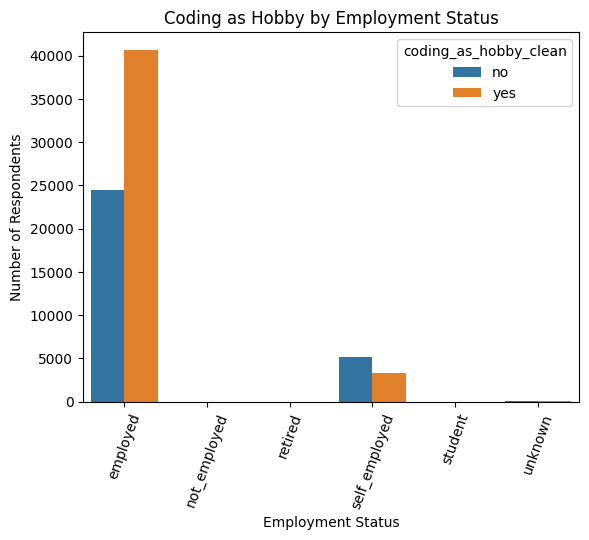

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart
sns.barplot(x='employment_clean', y='n', hue='coding_as_hobby_clean', data=chart_dat)
plt.xticks(rotation=70)
plt.xlabel('Employment Status')
plt.ylabel('Number of Respondents')
plt.title('Coding as Hobby by Employment Status')
plt.show()


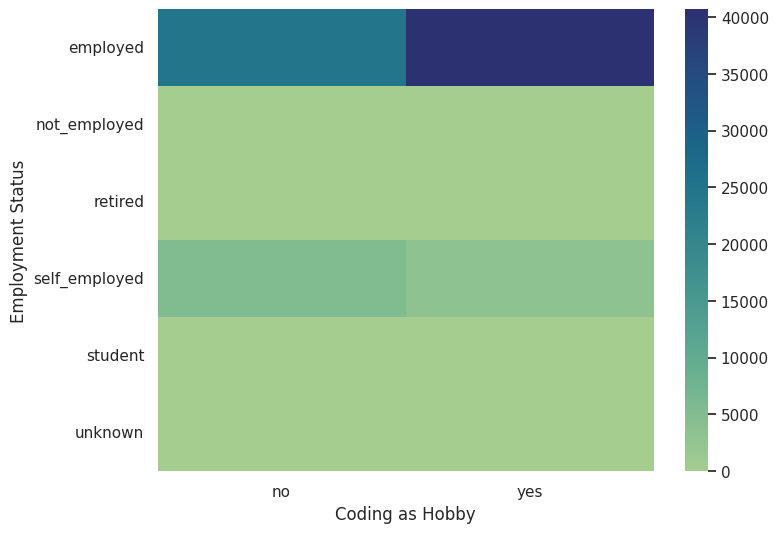

In [65]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pd.pivot_table(chart_dat, values='n', index='employment_clean', columns='coding_as_hobby_clean'), cmap='crest')
plt.xlabel('Coding as Hobby')
plt.ylabel('Employment Status')
plt.show()

Covariation will appear as a strong correlation between specific x values and specific y values.
From these visualisations, you can see that respondents that do not code as a hobby are mainly those that are employed or self-employed, and that employment status might influence whether individuals engage in coding as a hobby.

<a id='duplicates'></a>
## Duplicates

Duplicates are data points that are repeated in your dataset. An example could be when two users have the same identity number. These values should be removed. You could also look for fully identical rows in your dataset:

In [20]:
# Test for fully identical rows
survey_employment[survey_employment.duplicated()]

,response_id,q_120,profession,age,employment,remote_work,coding_as_hobby,ed_level,learn_code,learn_code_online,...,frequency_3,time_searching,time_answering,professional_tech,industry,survey_length,survey_ease,salary_usd,coding_as_hobby_clean,employment_clean


<a id='standardise'></a>
## Standardise

> REGULAR EXPRESSION PATTERNS: some text fields have to be in a certain pattern. For example, phone numbers may be required to have the pattern (999) 999--9999.

For each variable that we expect to be in a standardised format, we should:

-   test that all provided values for this variable are indeed in this format;
-   encode/store it in this format.

You might have noticed that, in our original dataset, we had 2 numerical variables, `comp_total` (the annual salary in the currency the respondent use day-to-day) and `salary_usd` (the annual salary converted into USD dollars). In order to be able to make predictions and comparisons, we will consider only the `salary_usd` variable to perform our analysis.

There are different ways we can quickly inspect our dataset.


**[Skimpy](https://github.com/aeturrell/skimpy)** is a light weight tool that provides summary statistics about variables in pandas data frames within the console or your interactive Python window.

In [21]:
from skimpy import skim

skim(survey_employment)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 89184  │ │ string      │ 80    │ │ coding_as_hobby_clean │                                │
│ │ Number of columns │ 86     │ │ float64     │ 3     │ │ employment_clean      │                                │
│ └───────────────────┴────────┘ │ category    │ 2     │ └───────────────────────┘                                │
│                                │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name     ┃ NA    ┃ NA %  ┃ mean      ┃ sd        ┃ p0 ┃ p25   ┃ p50    ┃ p75    ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ response_id     │     0 │     0 │     44590 │     25750 │  1 │ 22300 │  44590 │  66890 │    89180 │ ▇▇▇▇▇▇ │  │
│ │ comp_total      │ 40959 │ 45.93 │ 1.037e+42 │ 2.277e+44 │  0 │ 63000 │ 115000 │ 230000 │    5e+46 │   ▇    │  │
│ │ years_work_exp  │ 45605 │ 51.14 │     11.41 │     9.052 │  0 │     5 │      9 │     16 │       50 │  ▇▅▂▁  │  │
│ │ salary_usd      │ 41165 │ 46.16 │    103100 │    681400 │  1 │ 43910 │  74960 │ 121600 │ 74350000 │   ▇    │  │
│ └─────────────────┴───────┴───────┴───────────┴───────────┴────┴───────┴────────┴────────┴──────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                                ┃ NA           ┃ NA %         ┃ ordered         ┃ unique        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩  │
│ │ coding_as_hobby_clean                      │        15420 │        17.29 │ False           │             3 │  │
│ │ employment_clean                           │         1286 │         1.44 │ False           │             7 │  │
│ └────────────────────────────────────────────┴──────────────┴──────────────┴─────────────────┴───────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA         ┃ NA %       ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ q_120                              │          0 │          0 │                      2 │             178368 │  │
│ │ profession                         │          0 │          0 │                      7 │             627216 │  │
│ │ age                                │          0 │          0 │                    3.1 │             273300 │  │
│ │ employment                         │       1286 │       1.44 │                    2.9 │             256302 │  │
│ │ remote_work                        │      15374 │   

Each section summarizes variables of the same type. Numerical variables also include histograms.

The output from `skim()` separately summarizes categorical and continuous variables. For continuous variables you get information about the mean and median (**p50**) column. You know what the range of the variable is (**p0** is the minimum value, **p100** is the maximum value for continuous variables). You also get a measure of variability with the standard deviation (**sd**). It even quantifies the number of missing values (**NA**) and shows you the distribution or shape of each variable (**hist**)!

If we take a look closer we can see that `years_professional_coding` is a categorical variable. Let’s explore this variable:

In [22]:
#list all the possible values for years_professiona_coding variable
show(survey_employment['years_professional_coding'].value_counts(dropna=False))

It looks like two values are character strings instead of single numbers (`“Less than 1 year”`, `“More than 50 years”`). Let’s standardise these values so that the `years_professional_coding` variable transforms into a numerical variable:

In [23]:
# Define the function to convert character values to numbers and handle special values
def clean_years(years):
    if years == "Less than 1 year":
        return int(0)
    elif years == "More than 50 years":
        return int(51)
    elif isinstance(years, str) and years.isdigit(): # values are strings that represent numbers
        return int(years)
    else:
        return years

# Apply the function to the 'years_professional_coding' column
survey_prof = survey_employment.copy()
survey_prof['years_professional_coding_clean'] = survey_prof['years_professional_coding'].apply(clean_years)


# Display the cleaned variable
show(survey_prof[['years_professional_coding', 'years_professional_coding_clean']])

***
### ▶️ **It's your turn!** ###

`years_code` is reported as a categorical variables. Can you convert it to be numeric?

<details>
<summary>Solution</summary>

```python
#list all the possible values for years_professiona_coding variable
show(survey_prof['years_code'].value_counts(dropna=False))
#create a copy of the survey_prof dataframe called survey_code
survey_code = survey_prof.copy()
#apply the clean_years functions to create a new variable called years_code_clean
survey_code['years_code_clean'] = survey_code['years_code'].apply(clean_years)
#compare before and after
show(survey_code[['years_code', 'years_code_clean']])
```
</details>

***

In [24]:
#list all the possible values for years_professiona_coding variable
show(survey_prof['years_code'].value_counts(dropna=False))

In [25]:
survey_code = survey_prof
survey_code['years_code_clean'] = survey_code['years_code'].apply(clean_years)
show(survey_code[['years_code', 'years_code_clean']])

<a id='categorical'></a>
## Categorical data

**Categoricals** are a pandas data type corresponding to categorical variables in statistics. A categorical variable takes on a limited, and usually fixed, number of possible values (categories; levels in R). Examples are gender, social class, blood type, country affiliation, observation time or rating via Likert scales. In our dataset, `employment_clean` and `coding_as_hobby_clean` are categorical variables. We converted them to categorical type using `pd.Categorical()`. In those cases, we used the default behavior:

- Categories are inferred from the data;
- Categories are unordered.

In contrast to statistical categorical variables, categorical data might have an order (e.g. ‘strongly agree’ vs ‘agree’ or ‘first observation’ vs. ‘second observation’), but numerical operations (additions, divisions, …) are not possible.

All values of categorical data are either in categories or np.nan. Order is defined by the order of categories, not lexical order of the values. Internally, the data structure consists of a categories array and an integer array of codes which point to the real value in the categories array.

The categorical data type is useful in the following cases:

- A string variable consisting of only a few different values. Converting such a string variable to a categorical variable will save some memory;

- The lexical order of a variable is not the same as the logical order (“one”, “two”, “three”). By converting to a categorical and specifying an order on the categories, sorting and min/max will use the logical order instead of the lexical order;

- As a signal to other Python libraries that this column should be treated as a categorical variable (e.g. to use suitable statistical methods or plot types).

If a categorical variable represents an ordinal scale (i.e., categories have a meaningful order), we should preserve this ordinality during data preprocessing. The variable `company_size` is a categorical ordinal variable, but it's reported as a string (skim output):

In [26]:
# List all the possible values
survey_code['company_size'].value_counts(dropna=False)

company_size
NaN                                                   24141
20 to 99 employees                                    13380
100 to 499 employees                                  12218
10,000 or more employees                               7929
1,000 to 4,999 employees                               7235
2 to 9 employees                                       6439
10 to 19 employees                                     5254
500 to 999 employees                                   4472
Just me - I am a freelancer, sole proprietor, etc.     4196
5,000 to 9,999 employees                               2677
I don’t know                                           1243
Name: count, dtype: int64

Let’s convert `company_size` to a categorical variable by specifying the different categories and setting `order=True`:

In [27]:
# Define the mapping for the new categories
size_mapping_company = {
    "Just me - I am a freelancer, sole proprietor, etc.": "1",
    "2 to 9 employees": "2-9",
    "10 to 19 employees": "10-19",
    "20 to 99 employees": "20-99",
    "100 to 499 employees": "100-499",
    "500 to 999 employees": "500-999",
    "1,000 to 4,999 employees": "1,000-4,999",
    "5,000 to 9,999 employees": "5,000-9,999",
    "10,000 or more employees": ">10,000",
    "I don’t know": "unknown"
}

# Create a new column with the cleaned company sizes
survey_company = survey_code.copy()
survey_company['company_size_clean'] = survey_company['company_size'].map(size_mapping_company)

survey_company['company_size_clean'] = pd.Categorical(survey_company['company_size_clean'], categories=["1",
                                                                                                        "2-9",
                                                                                                        "10-19",
                                                                                                        "20-99",
                                                                                                        "100-499",
                                                                                                        "500-999",
                                                                                                        "1,000-4,999",
                                                                                                        "5,000-9,999",
                                                                                                        ">10,000",
                                                                                                        "unknown"],
                                                                                                        ordered=True)

# Examine the new levels
survey_company['company_size_clean'].unique()

[NaN, '2-9', '5,000-9,999', '100-499', '20-99', ..., '10-19', '>10,000', '500-999', '1', 'unknown']
Length: 11
Categories (10, object): ['1' < '2-9' < '10-19' < '20-99' ... '1,000-4,999' < '5,000-9,999' <
                          '>10,000' < 'unknown']

In [28]:
# Compare before and after
show(pd.crosstab(survey_company['company_size'], survey_company['company_size_clean']))

If there were new missing values, then you would know there was a mistake in your code.

***
### ▶️ **It's your turn!** ###

`age` is reported here in age ranges and is a categorical variables that is ordinal. In the skim() output, it is defined as a string. Can you convert it into a category?

<details>
<summary>Solution</summary>

```python
# List all the possible values
survey_company['age'].value_counts(dropna=False)
# Define the mapping for the new categories
size_mapping_age = {
    "Under 18 years old" : "<18",     
    "18-24 years old" : "18-24",
    "25-34 years old" : "25-34",
    "35-44 years old" : "35-44",
    "45-54 years old" : "45-54",
    "55-64 years old" : "55-64",
    "65 years or older" : ">65",
    "Prefer not to say" : "unknown"
}
#create a new dataframe survey_age
survey_age = survey_company.copy()
#create a new column age_clean and apply the mapping function
survey_age['age_clean'] = survey_age['age'].map(size_mapping_age)
#convert to category
survey_age['age_clean'] = pd.Categorical(survey_age['age_clean'], categories=["<18",
                                                                              "18-24",
                                                                              "25-34",
                                                                              "35-44",
                                                                              "45-54",
                                                                              "55-64",
                                                                              ">65",
                                                                              "unknown"],
                                                                              ordered=True)
#inspect
survey_age['age_clean'].unique()
# Compare before and after
show(pd.crosstab(survey_age['age'], survey_age['age_clean']))
```
</details>

***

In [29]:
# List all the possible values
survey_company['age'].value_counts(dropna=False)

age
25-34 years old       33247
35-44 years old       20532
18-24 years old       17931
45-54 years old        8334
Under 18 years old     4128
55-64 years old        3392
65 years or older      1171
Prefer not to say       449
Name: count, dtype: int64

In [30]:
size_mapping_age = {
    "Under 18 years old" : "<18",
    "18-24 years old" : "18-24",
    "25-34 years old" : "25-34",
    "35-44 years old" : "35-44",
    "45-54 years old" : "45-54",
    "55-64 years old" : "55-64",
    "65 years or older" : ">65",
    "Prefer not to say" : "unknown"
}
survey_age = survey_company.copy()
survey_age['age_clean'] = survey_age['age'].map(size_mapping_age)
survey_age['age_clean'] = pd.Categorical(survey_age['age_clean'], categories=["<18",
                                                                              "18-24",
                                                                              "25-34",
                                                                              "35-44",
                                                                              "45-54",
                                                                              "55-64",
                                                                              ">65",
                                                                              "unknown"],
                                                                              ordered=True)

survey_age['age_clean'].unique()

['18-24', '25-34', '45-54', '35-44', '<18', '55-64', '>65', 'unknown']
Categories (8, object): ['<18' < '18-24' < '25-34' < '35-44' < '45-54' < '55-64' < '>65' < 'unknown']

In [31]:
# Compare before and after
show(pd.crosstab(survey_age['age'], survey_age['age_clean']))

<a id='select_filter'></a>
## Select Variables and Filter Observations

We often want to subset our data in some way before we do many of our analyses. We may want to do this for a number of reasons (e.g., easier cognitively to think about the data, the analyses depend on the subsetting). The code below show the two main ways to subset your data:

-   *selecting* variables and
-   *filtering* observations.

Let's focus our analysis only on **developers**. We might want to to exclude from our analysis students, hobby programmers and former developers (`profession` variable). We might also want to exclude unemployed and retired respondents (`employment_clean` variable). Let's have a look at these two variables:

In [32]:
# Count profession
survey_age['profession'].value_counts(dropna=False)

profession
I am a developer by profession                                                           67237
I am not primarily a developer, but I write code sometimes as part of my work/studies     8954
I am learning to code                                                                     4961
I code primarily as a hobby                                                               4960
I used to be a developer by profession, but no longer am                                  1861
None of these                                                                             1211
Name: count, dtype: int64

In [33]:
# Count employment_clean
survey_age['employment_clean'].value_counts(dropna=False)

employment_clean
employed         65250
student           9475
self_employed     8407
not_employed      3397
NaN               1286
unknown            773
retired            596
Name: count, dtype: int64

We can filter (i.e. take out observations we don’t want) using boolean indexing to filter rows:

In [34]:
# Apply first filter
survey_filtered_profession = survey_age[survey_age['profession'] == 'I am a developer by profession']
print(f"Number of rows after profession filter: {survey_filtered_profession.shape[0]}")

# Apply second filter
survey_filtered_employment = survey_filtered_profession[
    (survey_filtered_profession['employment_clean'] == 'employed') |
    (survey_filtered_profession['employment_clean'] == 'self_employed')
]
print(f"Number of rows after employment filter: {survey_filtered_employment.shape[0]}")

# Final filtered data
survey_filtered = survey_filtered_employment

# A quicker way of doing this
# By using `|` we are saying we want employed or self_employed respondents.
# #In other words, if either are met, that observation will be kept:
survey_filtered = survey_age[(survey_age['profession'] == 'I am a developer by profession') &
                             ((survey_age['employment_clean'] == 'employed') |
                              (survey_age['employment_clean'] == 'self_employed'))]

Number of rows after profession filter: 67237
Number of rows after employment filter: 63533


The first filter selected only developers and reduced the dataset from 89184 respondents to 67237. The second filter excluded unemployed, students and retired respondents and the dataset was further reduced to 63533 respondents.

We can also select only the variables that are of interest for us today. In pandas, you can remove rows or columns by specifying label names and corresponding axis, or by directly specifying index or column names.

We might want to drop the variables `q120` (*You consent to providing your information to help us stay privacy compliant*), `survey_ease` (*How easy or difficult was this survey to complete?*), `survey_lenght` (*How do you feel about the length of the survey this year?*), `t_branch` (*Would you like to participate in the Professional Developer Series?*):

In [35]:
# Select specific columns
columns_to_drop = ["q_120", "survey_ease", "survey_length", "t_branch"]
survey_sel = survey_filtered.drop(columns=columns_to_drop)

In [36]:
# Display the number of columns before and after selection
print(f"Number of columns before selection: {survey_age.shape[1]}")
print(f"Number of columns after selection: {survey_sel.shape[1]}")

Number of columns before selection: 90
Number of columns after selection: 86


<a id='unusual_values'></a>
## Unusual values

> RANGE CONSTRAINTS: typically, numbers or dates should fall within a certain range.

<a id='outliers'></a>
### Outliers

Cleaning your data essentially is getting to know your data in greater detail to be able to make informed decisions about problems. For example, some variables cannot take on negative values as their scale of measurement renders negative values non-sensical (e.g., yearly salary). Even a value of zero might not be a valid value to observe. Sometimes, variables might have a valid lower boundary, upper boundary, or both.

> Outliers are observations that are unusual; data points that don’t seem to fit the pattern.

Sometimes outliers are data entry errors, sometimes they are simply values at the extremes that happened to be observed in this data collection, and other times they suggest important new discoveries.

Let's use the **matplotlib** library to create a histogram with salary on the x-axis:

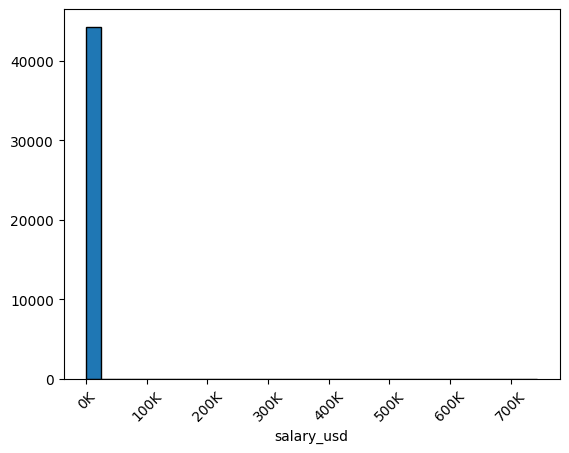

In [37]:
# Plot histogram using matplotlib
plt.hist(survey_sel['salary_usd'], bins=30, edgecolor='black')

# Format x-axis
fmt = '{x:,.0f}K'
tick = mtick.FuncFormatter(lambda x, pos: f'{x * 1e-5:,.0f}K')
plt.gca().xaxis.set_major_formatter(tick)

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.xlabel('salary_usd')
plt.show()

When you have a lot of data, outliers are sometimes difficult to see in a histogram. For example, take this distribution of the `salary_usd` variable. The only evidence of outliers is the unusually wide limits on the x-axis. There are so many observations in the common bins that the rare bins are very short, making it very difficult to see them (although maybe if you stare intently at the right of the bar you’ll spot something). To make it easy to see the unusual values, we need to zoom to small values of the y-axis:

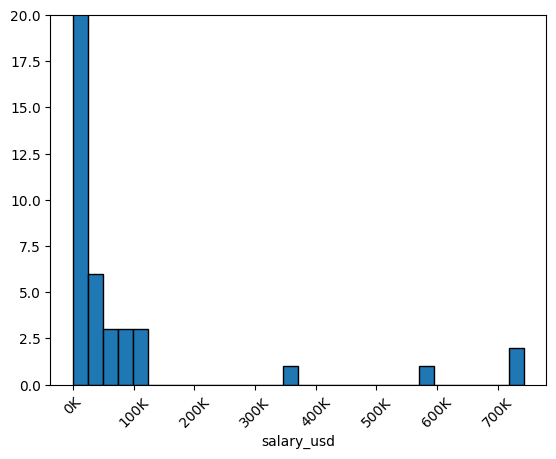

In [38]:
# Plot histogram using matplotlib
plt.hist(survey_sel['salary_usd'], bins=30, edgecolor='black')

# Format x-axis
fmt = '{x:,.0f}K'
tick = mtick.FuncFormatter(lambda x, pos: f'{x * 1e-5:,.0f}K')
plt.gca().xaxis.set_major_formatter(tick)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set y-axis limits
plt.ylim(0, 20)

plt.xlabel('salary_usd')
plt.show()

Outliers are innocent until proven guilty. With that being said, they should not be removed unless there is a good reason for that. For example, one can notice some weird, suspicious values that are unlikely to happen, and so decides to remove them. Though, they are worth investigating before removing. It is also worth mentioning that some models, like linear regression, are very sensitive to outliers. In other words, outliers might throw the model off from where most of the data lie.

You might be tempted to drop the entire row with the unusual values, but one invalid value doesn’t imply that all the other values for that observation are also invalid. Additionally, if you have low quality data, by the time that you’ve applied this approach to every variable you might find that you don’t have any data left.

Let’s have a better understanding on what’s going on with these values. The conversion rates could potentially introduce variability into the data. For example, if a currency is particularly strong against the USD, salaries in that currency might appear unusually high when converted to USD. Conversely, if a currency is weak against the USD, salaries might appear lower. Moreover, salaries might change significantly depending on the country respondends work in. Let’s have a closer look to how the salaries change depending on the country/continent.

But before doing this, let’s check country variable:

In [39]:
show(survey_sel['country'].value_counts())

There are a lot of countries with very few respondents. In the next steps, we will rename some country names for visualisation purposes, we will calculate the number of respondents by country and the country median salary:

In [40]:
# Make country names shorter
survey_sel['country'] = survey_sel['country'].replace({
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Venezuela, Bolivarian Republic of...': 'Venezuela',
    'Iran, Islamic Republic of...': 'Iran',
    'United States of America': 'United States',
    'Congo, Republic of the...': 'Democratic Republic of the Congo'
})

# Calculate number of respondents by country and median salary
country_n_resp = (survey_sel.groupby('country')
                  .agg(median_salary=('salary_usd', 'median'), n_resp=('country', 'size'))
                  .reset_index())

# Round median salary
country_n_resp['median_salary'] = country_n_resp['median_salary'].round()

# Sort by number of respondents
show(country_n_resp.sort_values(by='n_resp', ascending=False))

We can now generate a boxplot to visualise annual salary distribution by country. We will limit ourselves to countries with at least 30 respondents:

In [41]:
# Add number of respondents and median salary information
survey_resp = pd.merge(survey_sel, country_n_resp, on='country')

# Display the first few rows
show(survey_resp.head())

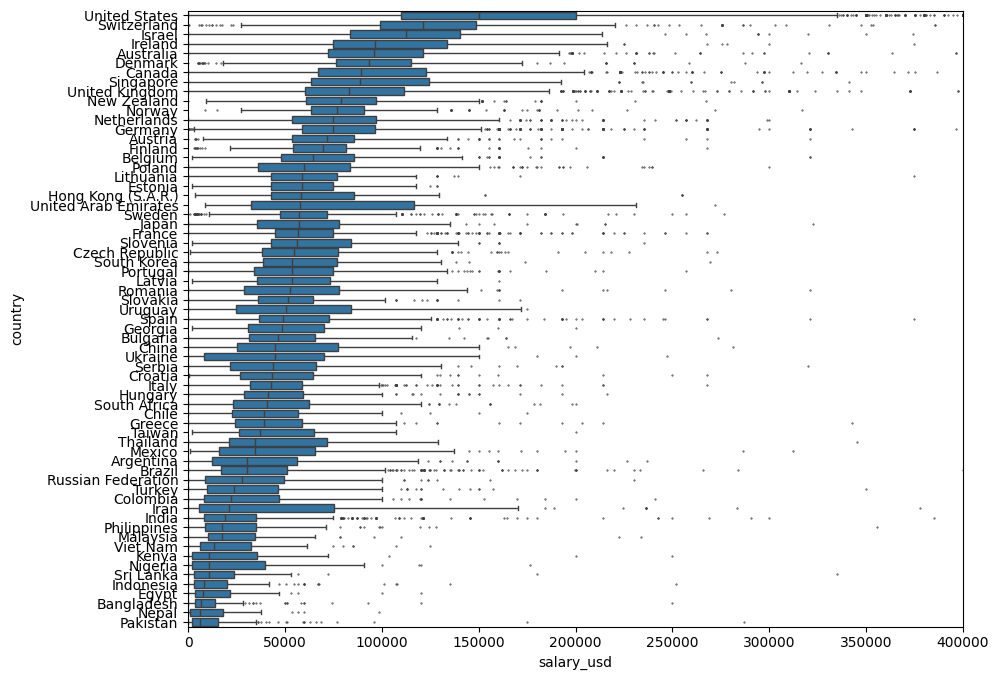

In [42]:
# Filter countries with at least 100 respondents
survey_resp_filtered = survey_resp[survey_resp['n_resp'] >= 100]

# Get the order of countries by median salary
order = survey_resp_filtered.groupby('country')['salary_usd'].median().sort_values(ascending=False).index

# Plot boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(data=survey_resp_filtered, y='country', x='salary_usd', fliersize=0.5, order=order)
plt.xlim(0, 400000)
sns.set_theme(style="white")
plt.show()

We can see that the United States has the highest median annual salary at ~150,000 USD, followed by Switzerland and Israel. The lower part of the graph is populated by Asian, South American and African countries.

The median annual salary varies a lot depending on the country. We might want to treat outliers differently, for example by considering the salary distribution of each country or continent.

***
### ▶️ **It's your turn!** ###

Let’s plot the variables `remote_work` or `manager_role` and look at how these might contribute to salary distribution in the different countries. For easier visualisation, select only respondent from `United States`, `Australia`, `Canada`, `Sweden`, `Italy` and `Singapore`.

<details>
<summary>Solution</summary>

```python
# Filter countries with at least 100 respondents and for selected countries
selected_countries = ['United States', 'Australia', 'Canada', 'Sweden', 'Italy', 'Singapore']
survey_resp_filtered = survey_resp[(survey_resp['n_resp'] >= 100) & (survey_resp['country'].isin(selected_countries))]

# Get the order of countries by median salary
order = survey_resp_filtered.groupby('country')['salary_usd'].median().sort_values(ascending=False).index

# Plot boxplot for remote_work
plt.figure(figsize=(10, 8))
sns.boxplot(data=survey_resp_filtered, y='country', x='salary_usd', hue='remote_work', fliersize=0.5, order=order)
plt.xlim(0, 400000)
plt.title('Salary Distribution by Country and Remote Work Status')
sns.set_theme(style="whitegrid")
plt.show()

# Plot boxplot for manager_role
plt.figure(figsize=(10, 8))
sns.boxplot(data=survey_resp_filtered, y='country', x='salary_usd', hue='manager_role', fliersize=0.5, order=order)
plt.xlim(0, 400000)
plt.title('Salary Distribution by Country and Manager Role Status')
sns.set_theme(style="whitegrid")
plt.show()
```
</details>

***

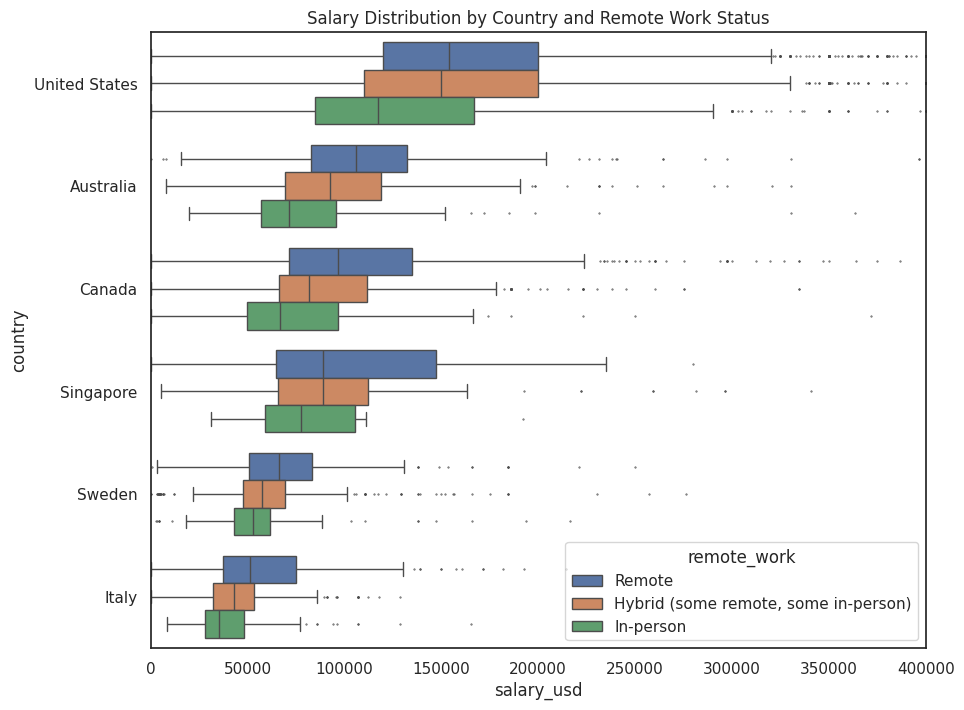

In [43]:
# Filter countries with at least 100 respondents and for selected countries
selected_countries = ['United States', 'Australia', 'Canada', 'Sweden', 'Italy', 'Singapore']
survey_resp_filtered = survey_resp[(survey_resp['n_resp'] >= 100) & (survey_resp['country'].isin(selected_countries))]

# Get the order of countries by median salary
order = survey_resp_filtered.groupby('country')['salary_usd'].median().sort_values(ascending=False).index

# Plot boxplot for remote_work
plt.figure(figsize=(10, 8))
sns.boxplot(data=survey_resp_filtered, y='country', x='salary_usd', hue='remote_work', fliersize=0.5, order=order)
plt.xlim(0, 400000)
plt.title('Salary Distribution by Country and Remote Work Status')
sns.set_theme(style="whitegrid")
plt.show()

Remote workers generally earn more than in-person or hybrid workers.

While these seem to be the general trend, keep in mind that individual salaries can vary widely based on factors like industry, years of experience, level of education, and specific skills.

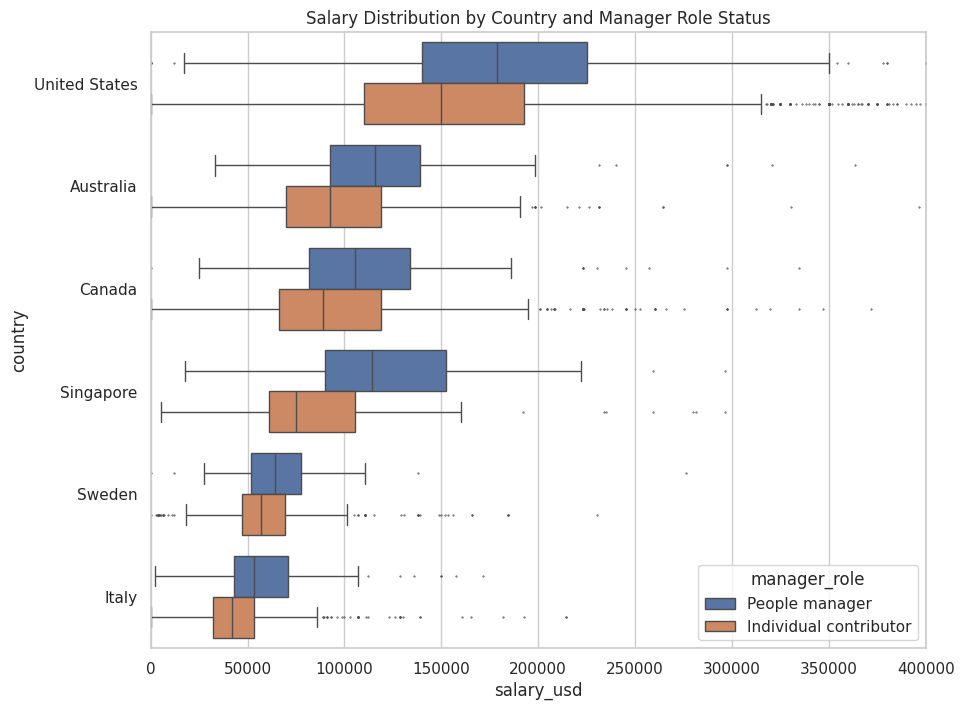

In [44]:
# Plot boxplot for manager_role
plt.figure(figsize=(10, 8))
sns.boxplot(data=survey_resp_filtered, y='country', x='salary_usd', hue='manager_role', fliersize=0.5, order=order)
plt.xlim(0, 400000)
plt.title('Salary Distribution by Country and Manager Role Status')
sns.set_theme(style="whitegrid")
plt.show()

Individual contributors (in orange) are employees who are not responsible for managing others. People managers (in blue) are employees who manage teams or departments. People managers generally earn more than individual contributors, but there can be exceptions, especially in countries with high salary variability like the United States.

<a id='missing'></a>
### Missing values

Missing values represent the unknown so they are “contagious”: almost any operation involving an unknown value will also be unknown.

We refer the missing data as **null**, **NaN**, or **NA** values in general.

Let's identify all locations in the survey data that have null (missing or NaN) data values. We can use the `isnull` method to do this. The isnull method will compare each cell with a null value. If an element has a null value, it will be assigned a value of True in the output object.

In [45]:
show(pd.isnull(survey_resp).head())

In [46]:
# Check is there any missing values across each column
show(survey_resp.isnull().any())

In [47]:
len(survey_resp[pd.isnull(survey_resp.salary_usd)]) ## how many missing values in salary_usd column?

19244

If we look at the `salary_usd` column in the surveys data we notice that there are **NaN** (*Not a Number*) values. NaN values are undefined values that cannot be represented mathematically. Pandas, for example, will read an empty cell in a CSV or Excel sheet as a NaN. NaNs have some desirable properties: if we were to average the `salary_usd` column without replacing our NaNs, Python would know to skip over those cells.

Given the fact the missing values are unavoidable leaves us with the question of what to do when we encounter them. There are several different ways in which we can deal with NAs.

<a id='drop'></a>
#### Drop

If missing values in a column are infrequent and occur randomly, the most straightforward approach is to remove/drop observations (rows) containing missing values. However, if a large portion of the column’s values are missing and this occurs randomly, it may be prudent to consider removing the entire column.

Let’s check whether there are any missing values for the `remote_work` variable:

In [48]:
len(survey_resp[pd.isnull(survey_resp.remote_work)]) ## how many missing values in remote_work column?

11

There are different ways we can inspect missing values in our dataset:

In [49]:
# get count of missing values of a particular column by group
# i.e., count of missing values of “salary_usd” column by group (“remote_work”)
survey_resp.groupby(['remote_work'])['salary_usd'].apply(lambda x: x.isnull().sum())

remote_work
Hybrid (some remote, some in-person)    8140
In-person                               3545
Remote                                  7548
Name: salary_usd, dtype: int64

The most basic plot for visualizing missing values is the bar chart. To get this, you can use the function `bar` in the **missingno** library:

<Axes: >

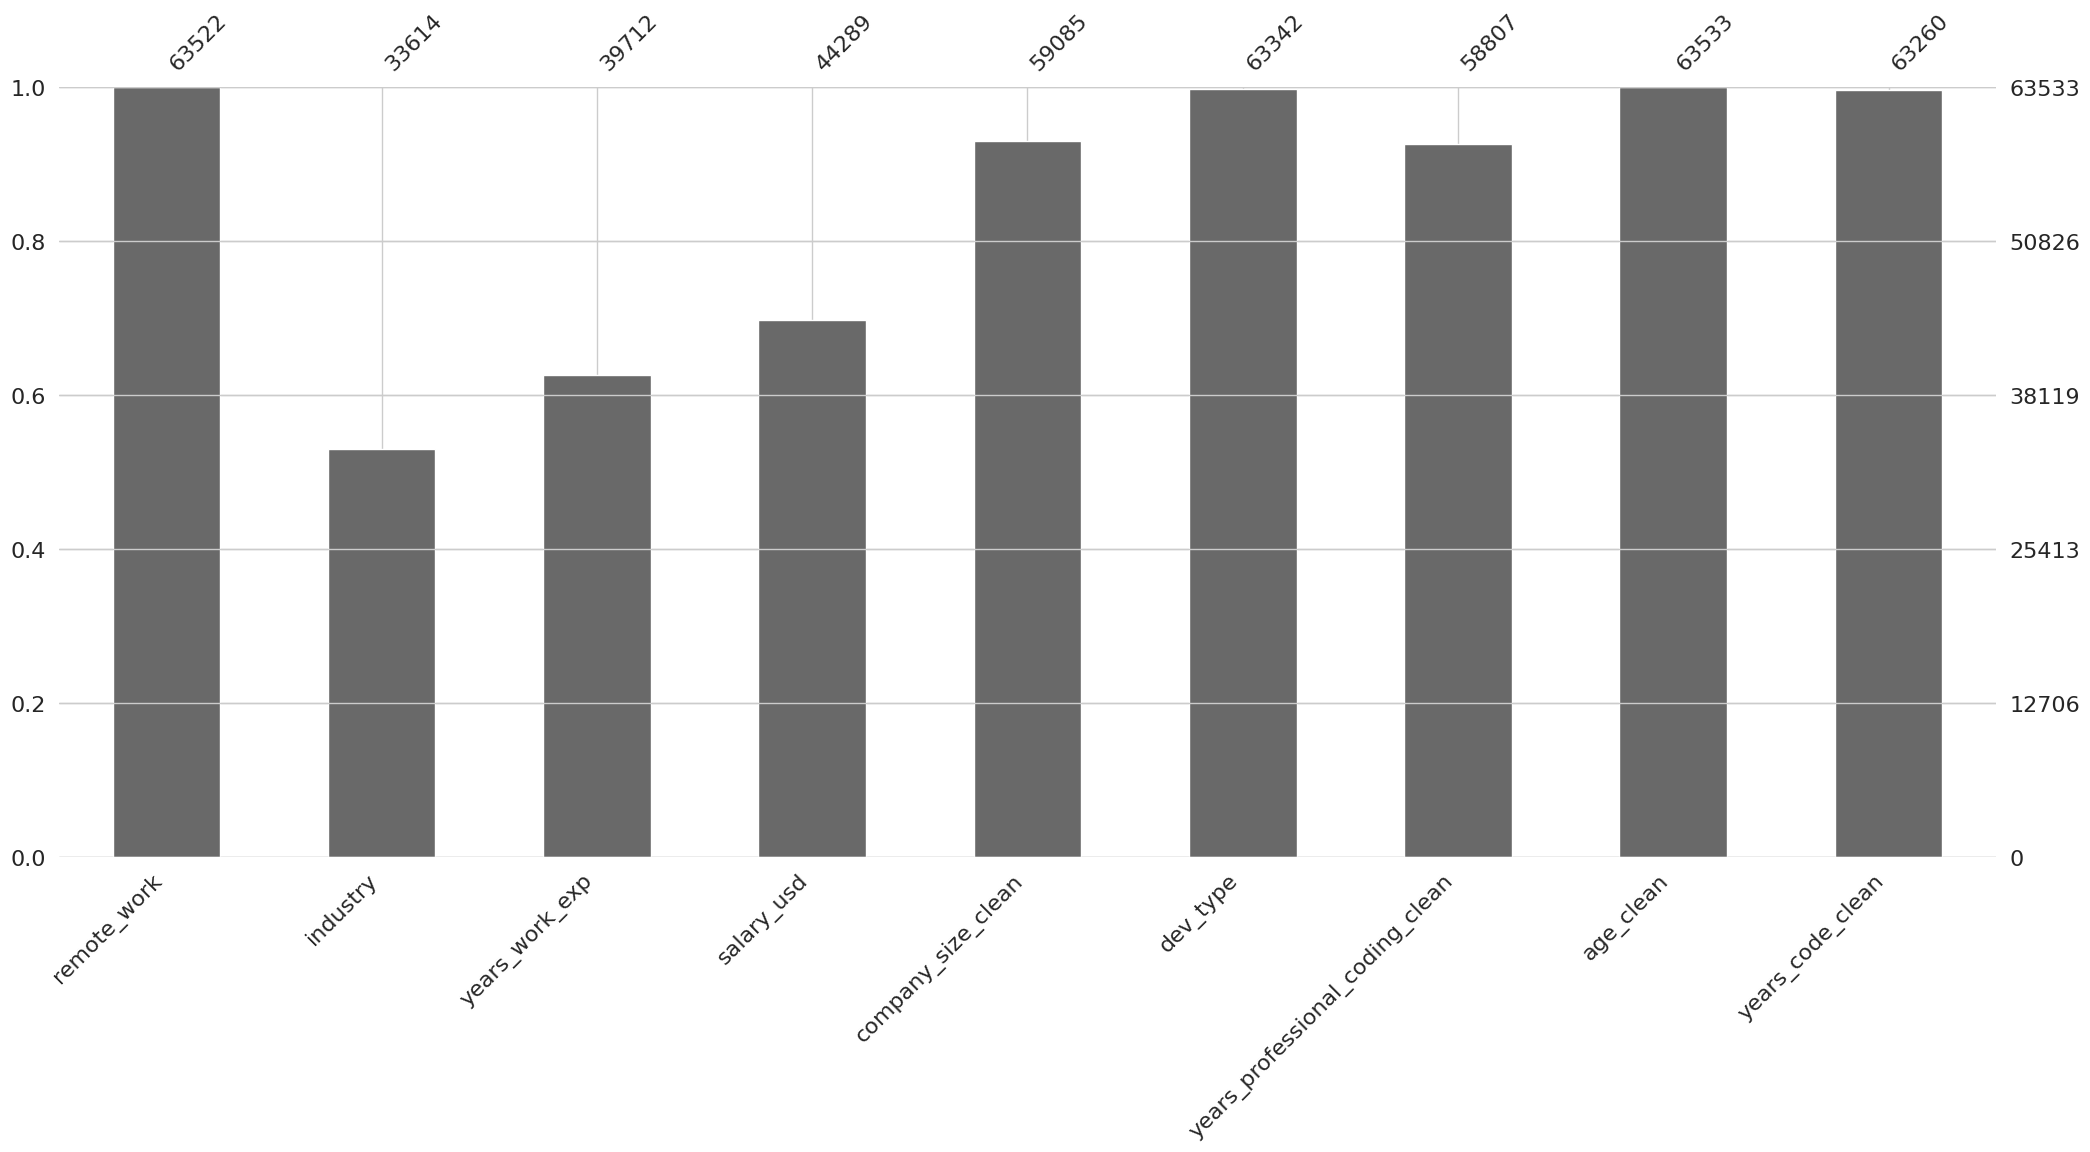

In [50]:
import missingno as msno

# Gives a bar chart of the missing values
msno.bar(survey_resp[['remote_work',
                         'industry',
                         'years_work_exp',
                         'salary_usd',
                         'company_size_clean',
                         'dev_type',
                         'years_professional_coding_clean',
                         'age_clean',
                         'years_code_clean']])

Here you can immediately see that the `industry`,`years_work_exp` and `salary_usd` features are seriously missing values. A closer look also reveals that the features `remote_work`, `dev_type` and `years_code_clean` are missing few values each.

It is the *nullity* matrix that allows us to see the distribution of data across all columns in the whole dataset. It also shows a sparkline (or, in some cases, a striped line) that emphasizes rows in a dataset with the highest and lowest nullity.

<Axes: >

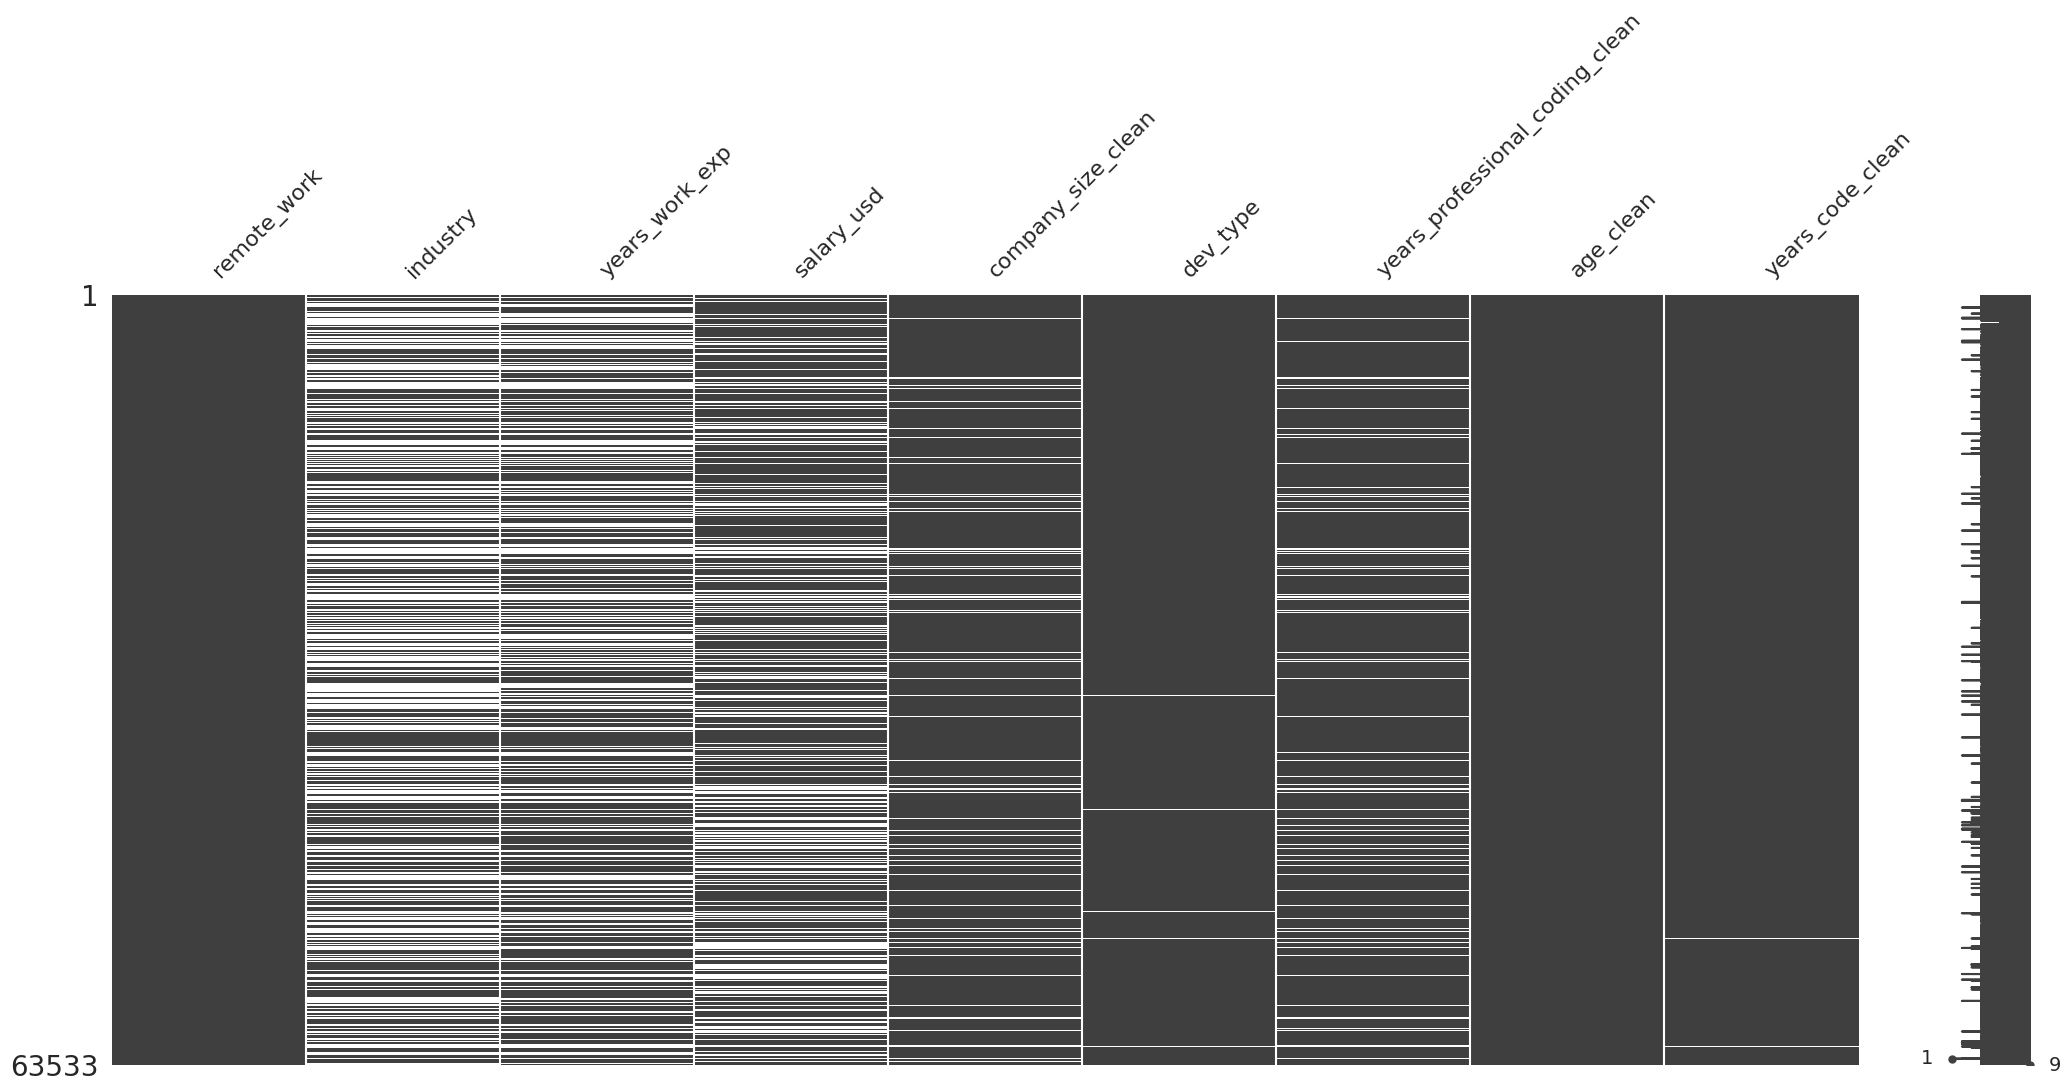

In [51]:
msno.matrix(survey_resp[['remote_work',
                         'industry',
                         'years_work_exp',
                         'salary_usd',
                         'company_size_clean',
                         'dev_type',
                         'years_professional_coding_clean',
                         'age_clean',
                         'years_code_clean']])


A final visualization you can use is the **heatmap**. This is slightly more complicated than the bar chart and the matrix plot. However, it can sometimes reveal interesting connections between missing values of different features.

To get a heatmap, you can use the function `heatmap()` in the missingno library:

<Axes: >

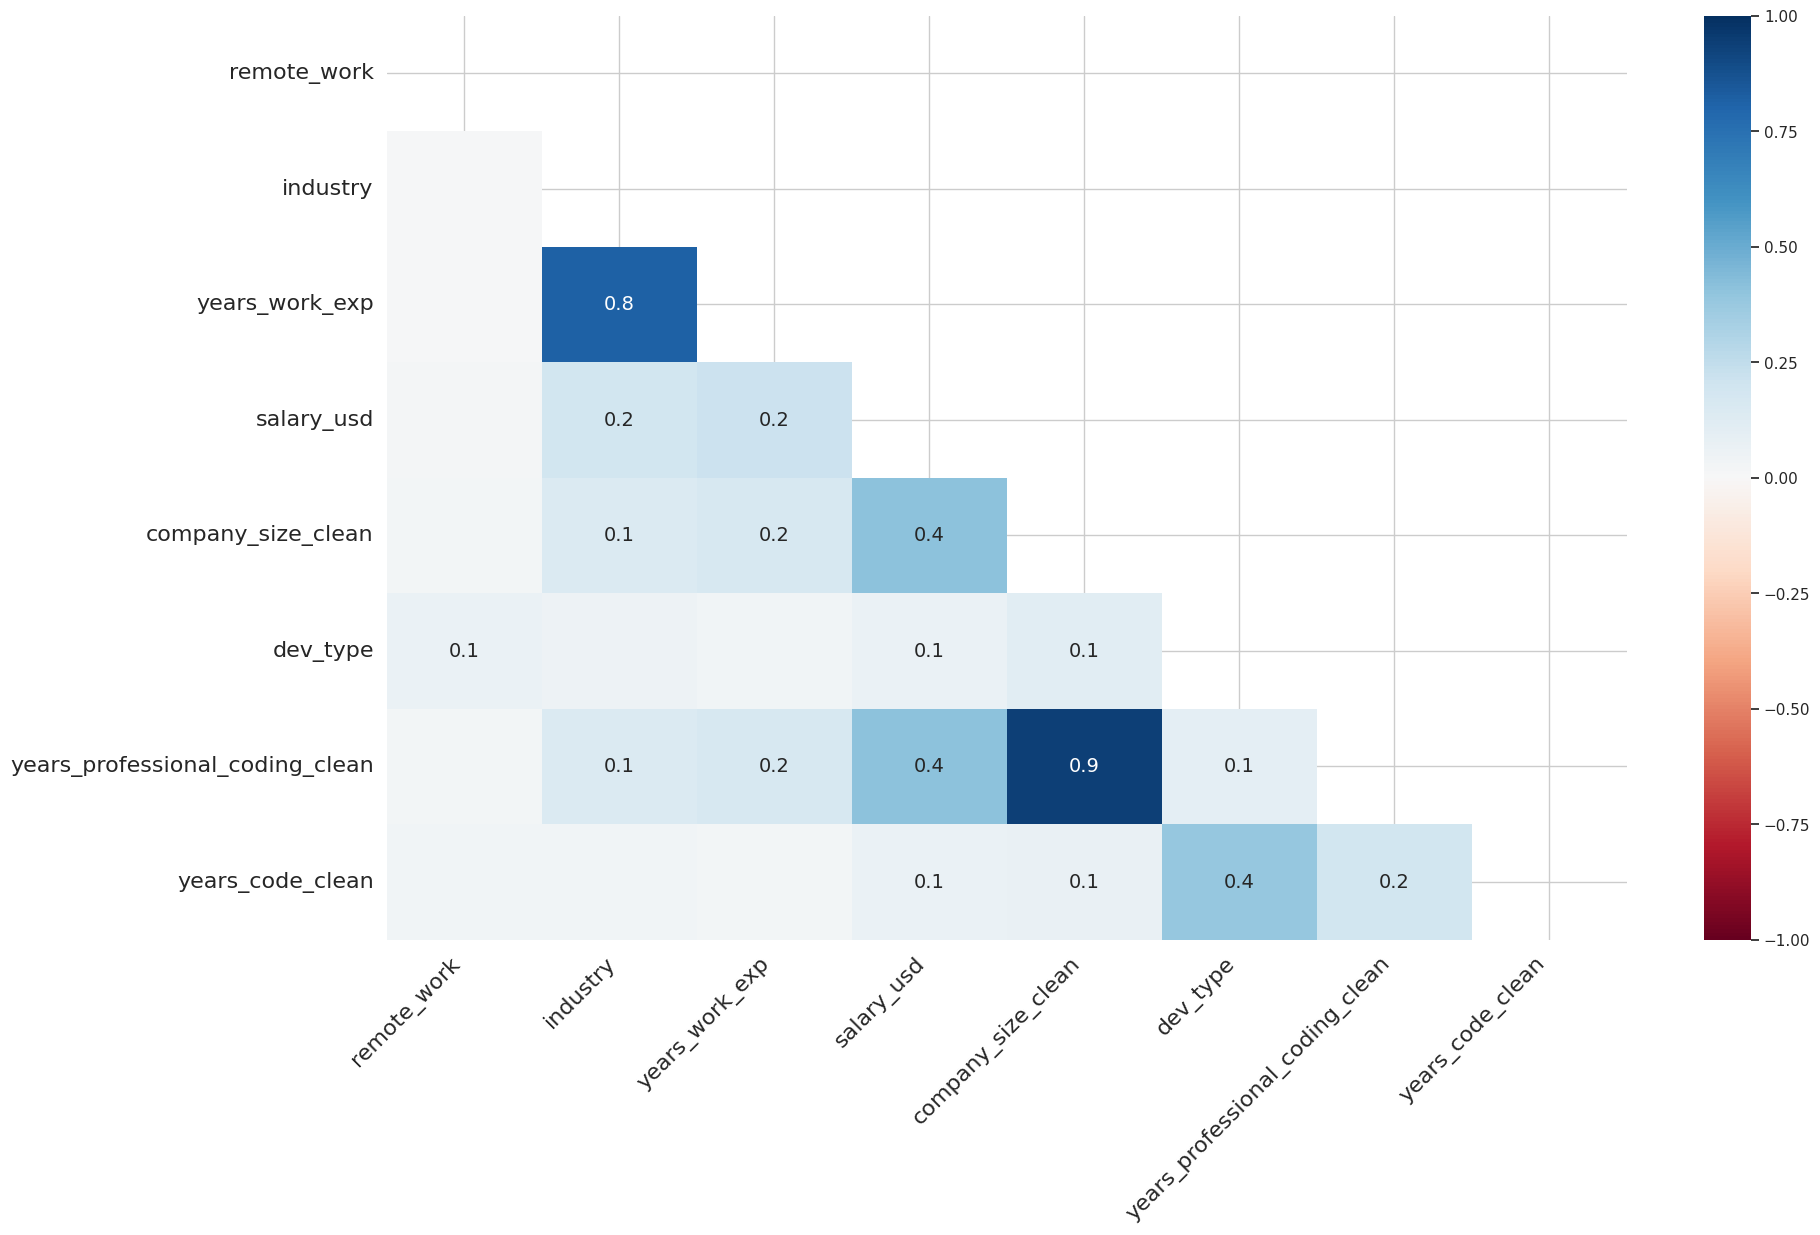

In [52]:
# Gives a heatmap of how missing values are related
msno.heatmap(survey_resp[['remote_work',
                         'industry',
                         'years_work_exp',
                         'salary_usd',
                         'company_size_clean',
                         'dev_type',
                         'years_professional_coding_clean',
                         'age_clean',
                         'years_code_clean']])

First of all, notice that there are only 8 features present in the heatmap. This is because there are only 8 features that are missing values. All the other features are discarded from the plot (only `age_clean` in this case).

To understand the heatmap, look at the value that corresponds to `company_size_clean` and `year_professional_coding_clean`. The value is 0.9. This means that there is a nearly perfect correspondence between missing values in `company_size_clean` and missing values in `year_professional_coding_clean` . You can also see this from the matrix plot you made before.

The values in the heatmap range between -1 and 1. A value of -1 indicates a negative correspondence: A missing value in feature A implies that there is not a missing value in feature B.

Finally, a value of 0 indicates that there is no obvious correspondence between missing values in feature A and missing values in feature B. This is the case for the `remote_work` feature.
The `remote_work` variables has very few missing values. Given the sample size of our dataset, we might want to drop these missing values and we can do this with the `dropna()` function:

In [53]:
# Drop rows where 'remote_work' is missing
survey_remote = survey_resp.dropna(subset=['remote_work'])

# Display the number of rows and columns before and after dropping NaN values
print(f"Number of rows before selection: {survey_resp.shape[0]}")
print(f"Number of rows after selection: {survey_remote.shape[0]}")

Number of rows before selection: 63533
Number of rows after selection: 63522


<a id='impute'></a>
#### Impute

> **Imputation** is a technique used for replacing the missing data with some substitute value to retain most of the data/information of the dataset.

Some argue that filling in the missing values leads to a loss in information. That’s because saying that the data is missing is informative in itself, and the algorithm should know about it. This is particularly important when the missing data doesn’t happen at random. Plotting the missingness patterns across different variables, as we did before, can provide insights into whether missing data occurs systematically or at random.

During the survey, maybe some people might have refused to answer a certain question. Maybe this is due to privacy concerns or confidentiality agreements with their employers.

As the variable `salary_usd` seems to miss completely at random, we can think of replacing the NA with the most frequent occurrence of the variable, which is the mean if the variable has a normal distribution, or the median otherwise.

##### Shape

Being able to describe the shape of your variables is necessary during your descriptive analysis.

When talking about the shape of one’s data, we’re discussing how the values (observations) within the variable are distributed. Often, we first determine how spread out the numbers are from one another (do all the observations fall between 1 and 10? 1 and 1000? -1000 and 10?). This is known as the **range** of the values. The range is described by the *minimum and maximum values taken by observations in the variable* and we can have a look at the range of the `salary_usd` variable using `min()` and `max()`:

In [54]:
# Calculate the minimum and maximum of 'salary_usd'
min_salary = survey_resp['salary_usd'].min()
max_salary = survey_resp['salary_usd'].max()

# Print the range
print(f"Range of 'salary_usd': {min_salary} - {max_salary}")

Range of 'salary_usd': 1.0 - 74351432.0


Let's visualise the distribution of this data (i.e. how the data are spread out over the range):

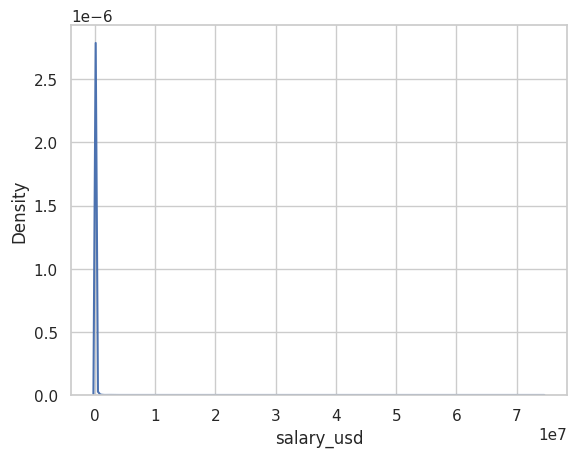

In [55]:
# Create a density plot of 'salary_usd'
sns.kdeplot(data=survey_remote, x='salary_usd')

# Set the background to white
sns.set_style("whitegrid")

# Display the plot
plt.show()

Here we see that the data are *skewed right*, given the shift in values away from the right, leading to a long right tail. Here, most of the values are at the lower end of the range.

<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/skewed_dist.png?raw=1" width="70%"/>

Let’s replace the missing values in the `salary_usd` variable with the median value of `salary_usd` for each country that we had previously calculated:

In [56]:
# Copy the DataFrame
survey_proc = survey_remote.copy()

# Replace missing values in 'salary_usd' with the median value for each country
survey_proc['salary_usd'] = survey_proc['salary_usd'].fillna(survey_proc['median_salary'])

# Check how many missing values are left in the 'salary_usd' column
len(survey_proc[pd.isnull(survey_proc.salary_usd)])

14

We still have 14 missing values in the `salary_usd` variable. What are these?

In [57]:
# Filter rows where 'salary_usd' is missing and select certain columns
survey_proc_na_salary = survey_proc[survey_proc['salary_usd'].isna()][['country', 'salary_usd', 'median_salary', 'n_resp']]

# Display the DataFrame
show(survey_proc_na_salary)

These are those countries with less than 30 respondents. As there are very few salary observations for these countries, it wasn’t possible to calculate the median salary. Depending on your main research question, you might want to drop these rows.



<a id='relationship'></a>
## Relationship

Sometimes missing values don’t occur randomly. Let’s consider the `years_professional_coding_clean` variable. This variable represents the number of years a respondent has been coding professionally. Younger respondents or those who are new to the workforce might be more likely to have missing values in this variable because they haven’t been coding professionally for many years.

To verify this, we could explore the relationship between `years_professional_coding_clean` and other variables such as `years_work_exp_clean`. If there’s a pattern where younger respondents or those with fewer years of working experience tend to have missing values in `years_professional_coding_clean`, it suggests that the missingness is not random but related to certain characteristics of the respondents.

You’ve already seen one great way to visualise the covariation between two categorical variables. Let's now visualise covariation between two continuous variables by drawing a **scatterplot**. You can see covariation as a pattern in the points. For example, you can see an exponential relationship between years of professional coding experience and years of working experience:

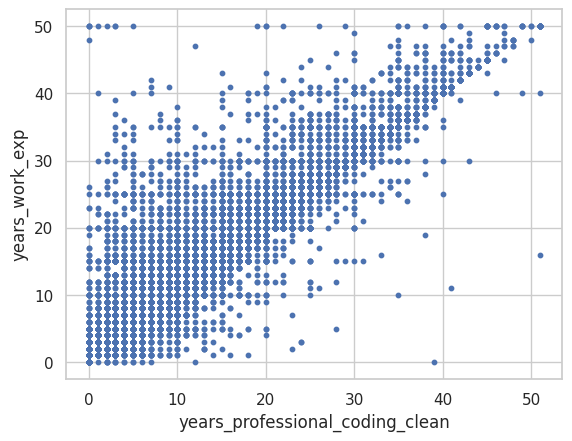

In [58]:
x_axis = 'years_professional_coding_clean'
y_axis = 'years_work_exp'

# Only plot finite (ie. non NaN) data
survey_proc_plot = survey_proc.dropna(subset=[x_axis, y_axis])
x_data = survey_proc_plot[x_axis]
y_data = survey_proc_plot[y_axis]

plt.scatter(x_data,y_data, s=10)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()

Scatterplots become less useful as the size of your dataset grows, because points begin to overplot, and pile up into areas of uniform black (as above). One way to fix the problem is by using the alpha argument to add transparency:

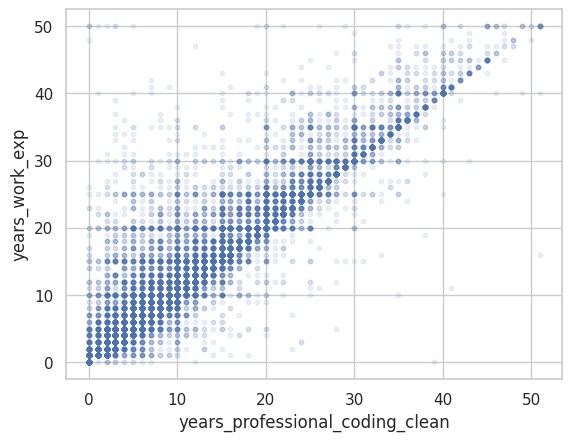

In [59]:
plt.scatter(x_data, y_data, s=10, alpha=0.1)
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()

Let's fit a *trend* line:

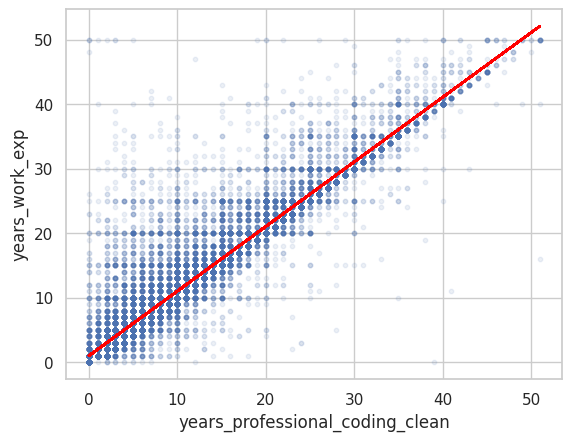

In [60]:
# Fit a linear trend line
z = np.polyfit(x_data, y_data, 1)
p = np.poly1d(z)

# Plot the scatter plot with the trend line
plt.scatter(survey_proc[x_axis],survey_proc[y_axis], s=10, alpha=0.1)
plt.plot(survey_proc[x_axis], p(survey_proc[x_axis]), color='red')
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()


This line indicates an upward trend, suggesting that as professional coding experience increases, overall work experience also increases. This trend line suggests a positive correlation between the two variables, meaning that individuals with more professional coding experience also tend to have more overall work experience.

<a id='correlation'></a>
### Correlation

We might want to look at the relationships between all of our continuous variables. A good way to do this is to use a visualization of **correlation**. Correlation is a measure of the relationship or interdependence of two variables. In other words, how much do the values of one variable change with the values of another. Correlation can be either positive or negative and it ranges from -1 to 1, with 1 and -1 indicating perfect correlation (1 being positive and -1 being negative) and 0 indicating no correlation. Let's first calculate a correlation matrix:

In [61]:
survey_num = survey_proc.select_dtypes(include=[np.number])
corr = survey_num.corr(method = 'pearson')
show(corr)

We can now use this correlation matrix to generate a correlation plot:

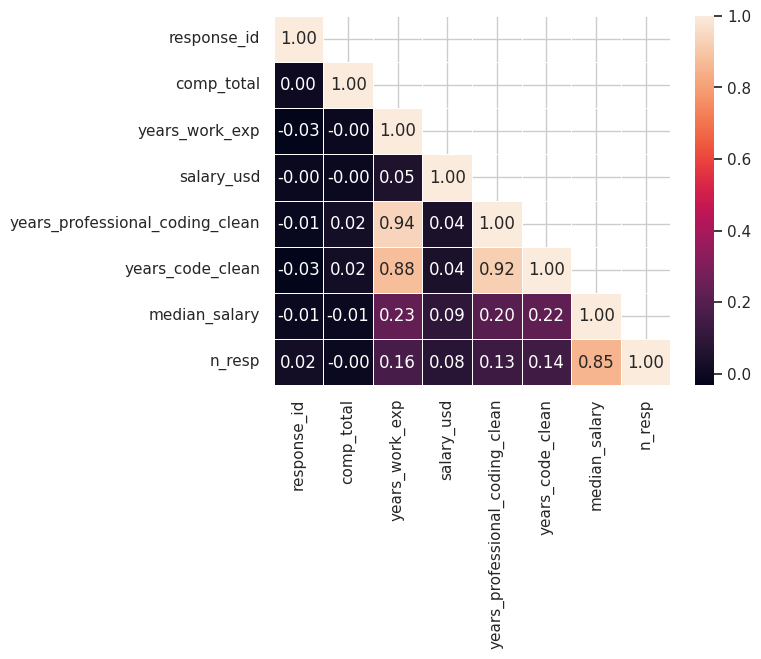

In [62]:
mask = np.triu(np.ones_like(corr, dtype=bool))
mask[corr==1] = False

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linewidth=.5)
plt.show()

Positive values (in orange/red) indicate positive correlations, with numerical values displayed within each cell to quantify the strength of each correlation. There are some cells with zero value which are colored black indicating no observed correlation between those pairs of variables.

We can see that the `years_professional_coding_clean` variable is positively correlated to the `years_work_exp` variable, as previously observed.

<a id='verifying'></a>
## Verifying

After your data inspection and cleaning, you should verify correctness by re-inspecting the data. We have already discussed most of these things but here is a general summary:

<a id='accuracy'></a>
### Accuracy

The degree to which the data is close to the true values. While defining all possible valid values allows invalid values to be easily spotted, it does not mean that they are accurate. A valid street address mightn’t actually exist. A valid person’s eye colour, say blue, might be valid, but not true (doesn’t represent the reality). Another thing to note is the difference between accuracy and precision. Saying that you live on the Earth is, actually true. But, not precise. Where on the earth? Saying that you live at a particular street address is more precise.

<a id='completeness'></a>
### Completeness

The degree to which all required data is known. Missing data is going to happen for various reasons. One can mitigate this problem by questioning the original source if possible, say re-interviewing the subject.

<a id='consistency'></a>
### Consistency

The degree to which the data is consistent, within the same data set or across multiple data sets.

As we have already seen, inconsistency occurs when two values in the data set contradict each other. A valid age, say 10, mightn’t match with the marital status, say divorced. A customer is recorded in two different tables with two different addresses. Which one is true?

<a id='uniformity'></a>
### Uniformity

The degree to which the data is specified using the same unit of measure. The weight may be recorded either in pounds or kilos. The date might follow the USA format or European format. The currency is sometimes in USD and sometimes in YEN. And so data must be converted to a single measure unit.

**Pandas_profiling** displays descriptive overview of the data sets, by showing the number of variables, observations, total missing cells, duplicate rows, memory used and the variable types. Then, it generates detailed analysis for each variable, class distributions, interactions, correlations, missing values, samples and duplicated rows, which you can observe by clicking each tab.

In [63]:
# Generate a data profiling report
#report = ProfileReport(survey_proc, title='my data', minimal=True) #set minimal to True for less computational time
#report.to_file("my_data_report.html")

Similarly, **SweetViz** is an open-source Python library, this is used for automated exploratory data analysis (EDA), it helps data analysts/scientists quickly generate beautiful & highly detailed visualizations. The output we get is a fully self-contained HTML application. The system built reports around quickly visualizing the target values & comparing datasets.

In [64]:
import sweetviz as sv

#assuming we want to predict the variable salary_usd

# Remove rows where 'salary_usd' is NaN
#survey_report_salary = survey_proc.dropna(subset=['salary_usd'])

# Then you can analyze the cleaned data
#sv_report = sv.analyze(survey_report_salary, target_feat='salary_usd')

# show the report in a form of an HTML file
#sv_report.show_html('sv_report.html')


<a id='reporting'></a>
### Reporting

Reporting how healthy the data is, is equally important to cleaning. Be sure to include in your report (e.g. Jupyter notebook/Quarto) what were the methods used to clean the data and why, as different methods can be better in different situations or with different data types. By documenting your process in this way, you provide valuable context and ensure that your data cleaning process is reproducible and transparent

<a id='next'></a>
## What's next

*Congratulations on completing your first exploratory data analysis (EDA)!*

You've journeyed through the intricate landscape of the Stack Overflow dataset, exploring developers' demographics, professional experiences, and work dynamics.

Now that our data is primed for analysis, the possibilities are endless.

At the *Sydney Informatics Hub (SIH)*, we offer a myriad of avenues for further exploration and learning, ensuring that you're well-equipped to harness the power of data.

Have a look at our *training calendar* [here](https://www.sydney.edu.au/research/facilities/sydney-informatics-hub/workshops-and-training/training-calendar.html).

***
### ℹ️ **Additional information** ###

There are a couple of other things that you will need to know and that are not covered in this tutorial:

- **Joining dataframes**: this is common in many situations including health records and longitudinal studies.  Please have a look at this *[link](https://pandas.pydata.org/docs/user_guide/merging.html)* for additional resources;

<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/Joining.jpg?raw=1" width="70%"/>

- **Reshaping dataframes**: converting your data from wide-to-long or from long-to-wide data formats. Please have a look at this *[link](https://pandas.pydata.org/docs/user_guide/reshaping.html)* for additional resources.

<img src="https://github.com/Sydney-Informatics-Hub/EDAinPy/blob/tomm-updates/fig/reshape.png?raw=1" width="70%"/>

***